In [1]:
from __future__ import print_function, division, absolute_import, unicode_literals
%load_ext tensorboard
import tensorflow as tf
print(tf.__version__)
tf.test.is_gpu_available(
    cuda_only=True,
    min_cuda_compute_capability=None
)

2.0.0


True

In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from PIL import ImageOps, Image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
print('setup finished')

setup finished


# Setting perameters

In [3]:
im_width = 256
im_height = 256
path_train = r'/data/student/training/'
classes = ['dark_dense_distribution', 'Elongated_nuclei','light_dense_istribution','light_distribution',
           'No_nuclei_with_uniform_texture','No_nuclei_with_unstructured','Red_texture',  'Round_nuclei','Mixed']

In [4]:
path_train + 'images'

'/data/student/training/images'

In [5]:
palette = np.array([
    [128,0,0],
    [128,8,0],
    [0,0,255],
    [0,128,0],
    [255,255,0],
    [255,105,180],
    [255,0,0],
    [255,165,0],
    [128,128,128]], dtype=np.uint8)
palette = np.divide(palette, 255)

In [6]:
palette.shape

(9, 3)

In [7]:
palette

array([[0.50196078, 0.        , 0.        ],
       [0.50196078, 0.03137255, 0.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 0.50196078, 0.        ],
       [1.        , 1.        , 0.        ],
       [1.        , 0.41176471, 0.70588235],
       [1.        , 0.        , 0.        ],
       [1.        , 0.64705882, 0.        ],
       [0.50196078, 0.50196078, 0.50196078]])

In [8]:
def one_hot_encode( mask, palette):
        """
        Converts mask to a one-hot encoding specified by the semantic map.
        """
        one_hot_map = []
        for colour in palette:
            class_map = tf.reduce_all(tf.equal(mask, colour), axis=-1)
            one_hot_map.append(class_map)
        one_hot_map = tf.stack(one_hot_map, axis=-1)
        one_hot_map = tf.cast(one_hot_map, tf.float32)
        
        return one_hot_map

In [12]:
def patch_maker(savedir, path, filename, target_size=(256,256)):
    
    '''opens one images at a time and saves them into patches of given hight and width. 
    It also handels RGBA format issues'''
    if not os.path.isdir(savedir):
            os.mkdir(savedir)
    img = Image.open(path + filename)
    width, height = img.size

    start_pos = start_x, start_y = (0, 0)
    cropped_image_size = w, h = target_size

    new_name = filename.split('.')[0]
    frame_num = 1
    for col_i in tqdm_notebook(range(0, width, w)):
        for row_i in range(0, height, h):
            crop = img.crop((col_i, row_i, col_i + w, row_i + h))
            save_to= os.path.join(savedir, new_name + "_{:04}.jpg")
            if crop.mode in ('RGBA', 'LA'):
                background = Image.new(crop.mode[:-1], crop.size, (255,255,255))
                background.paste(crop, crop.split()[-1])
                crop = background
            crop.save(save_to.format(frame_num))
            frame_num += 1

In [15]:
def save_patches(savedir, path, images, masks):
    if not os.path.isdir(savedir):
            os.mkdir(savedir)
    path_im = path + images 
    path_ms = path + masks
    ids = next(os.walk(path_ms))[2]
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        '''image pathing'''
        print(id_.replace('.png', '.tif'))
        patch_maker(savedir + 'images', path_im, id_.replace('.png', '.tif'))
        
        '''mask patching'''
        patch_maker(savedir + 'masks', path_ms, id_)


# Testing the save function

In [16]:
save_patches(savedir= '/data/student/training/test/' ,path= '/data/student/training/', images= 'testIm/', masks= 'testMa/')

S_385 (26).tif


# only run this cell if you dont have patches

In [17]:
# patches for images 
save_patches('/data/student/training/patches/',path_train, 'images/', 'masks/')


S_385 (35).tif



S_385 (34).tif



S_385 (33).tif



S_385 (32).tif



S_385 (31).tif



S_385 (30).tif



S_385 (29).tif



S_385 (23).tif



S_385 (18).tif



S_385 (17).tif



S_385 (16).tif



S_385 (15).tif



S_385 (14).tif



S_385 (19).tif



S_385 (20).tif



S_385 (21).tif



S_385 (22).tif



S_385 (24).tif



S_385 (25).tif



S_385 (26).tif



S_385 (27).tif



S_385 (28).tif



S_385 (62).tif


/home/student/anaconda3/envs/DLmodel/lib/python3.7/site-packages/PIL/Image.py:2731: DecompressionBombWarning: Image size (128403763 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,



S_385 (66).tif



S340 (54).tif



S340 (53).tif



S340 (28).tif



S340 (35).tif



S340 (36).tif



S340 (56).tif



S340 (59).tif



S340 (60).tif



S340 (26).tif



S340 (27).tif



S340 (55).tif



S340 (61).tif



S340 (47).tif



S340 (46).tif



S340 (25).tif



S340 (48).tif



S340 (38).tif



S340 (39).tif



S340 (37).tif



S340 (45).tif


In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [44]:
data_gen_args = dict(rotation_range=20,
                    width_shift_range=0.01,
                    height_shift_range=0.01,
                    shear_range=0.01,
                    zoom_range=0.01,
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='nearest')

In [117]:
def trainGenerator(batch_size,train_path,aug_dict=None,target_size = (64,64),seed = 42):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    if aug_dict: 
        image_datagen = ImageDataGenerator(**aug_dict)
        mask_datagen = ImageDataGenerator(**aug_dict)
    else:
        image_datagen = ImageDataGenerator()
        mask_datagen = ImageDataGenerator()
    image_generator = image_datagen.flow_from_directory(
        train_path + 'images/',
        class_mode = None,
        target_size = target_size,
        batch_size = batch_size,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path + 'masks/',
        class_mode = None,
        target_size = target_size,
        batch_size = batch_size,
        seed = seed)
    return  (pair for pair in zip(image_generator, mask_generator))
    

In [118]:
train_gen = trainGenerator(8, path_train + '/patches/')

Found 37228 images belonging to 1 classes.
Found 37228 images belonging to 1 classes.


In [119]:
def plot_img(ix):
    x, y = next(train_gen)
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    
    ax[0].imshow(((x[0]).astype(np.uint8)))
    ax[0].set_title('Image')

    ax[1].imshow(((y[0]).astype(np.uint8)))
    ax[1].set_title('mask');
    fig.show()



/home/student/anaconda3/envs/DLmodel/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


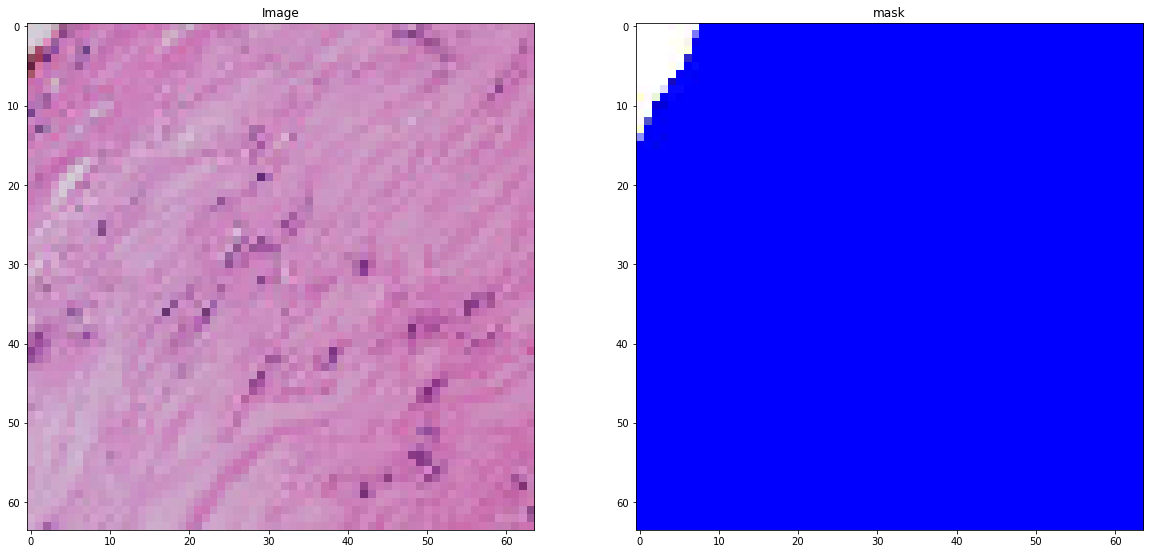

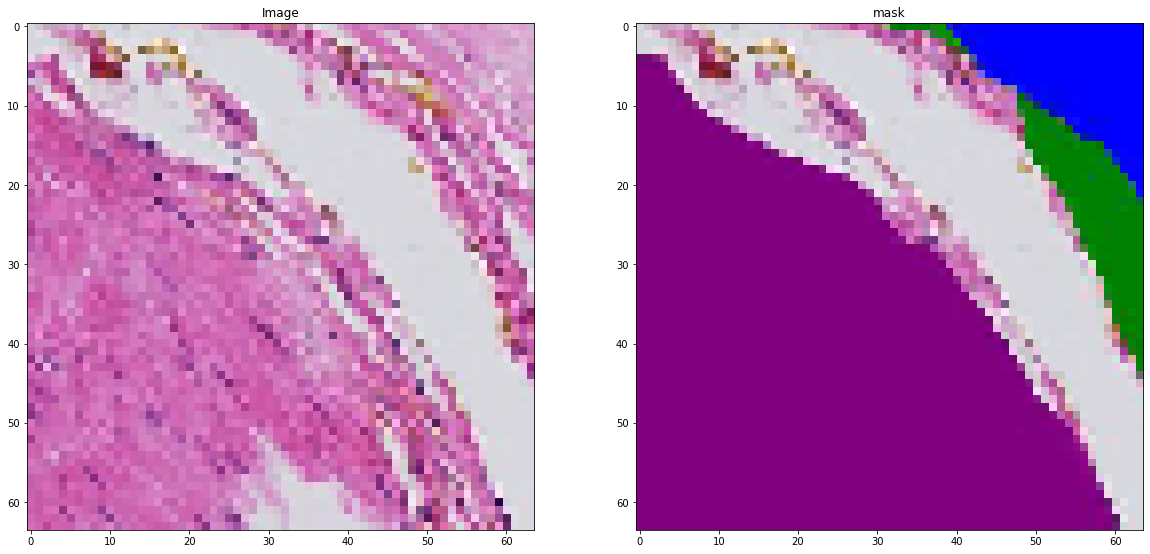

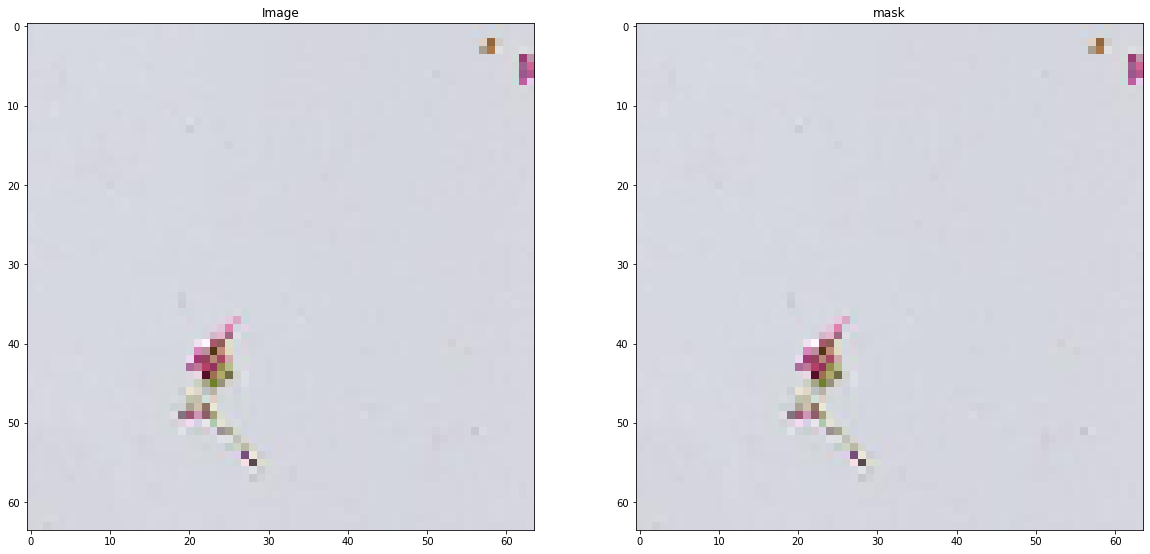

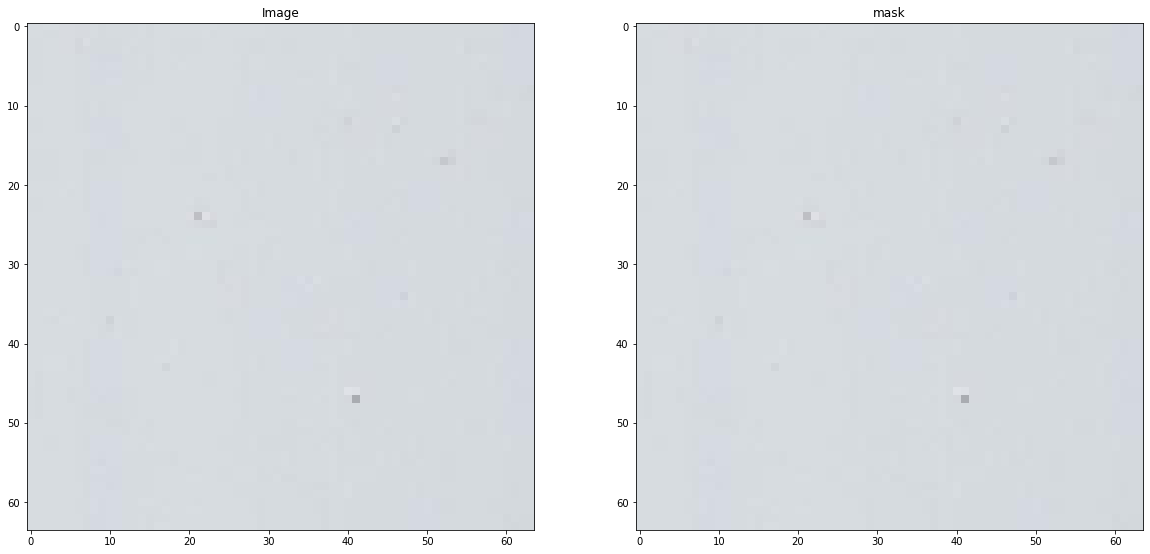

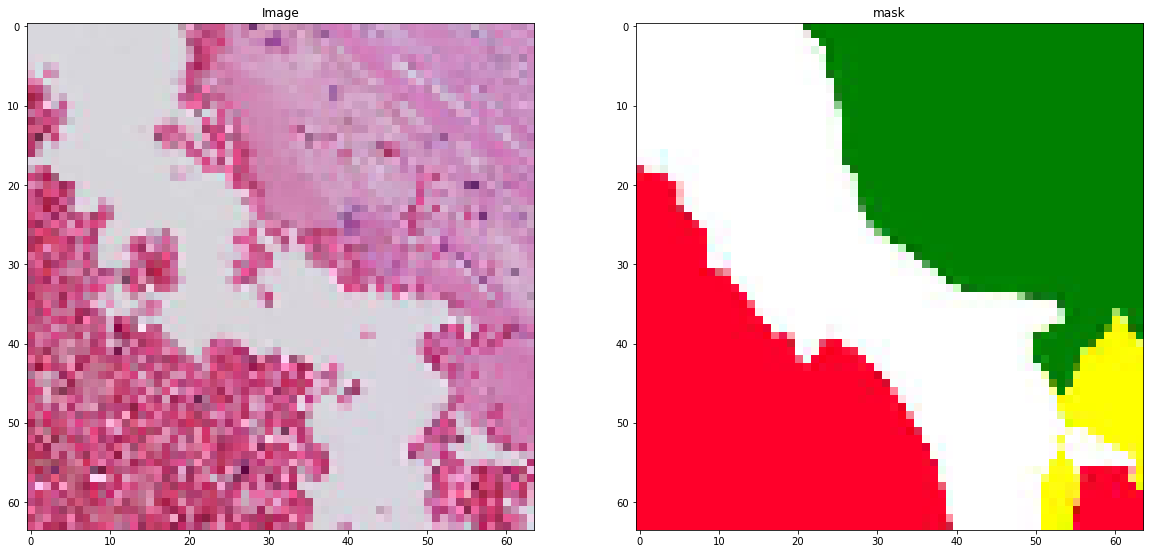

In [120]:

for i in range(0,5):
    plot_img(i)

In [121]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    
    
    
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [122]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(9, (1, 1), activation='softmax') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [123]:
def dice_coef(y_true, y_pred):
    smooth = 1e-5
    
    y_true = tf.round(tf.reshape(y_true, [-1]))
    y_pred = tf.round(tf.reshape(y_pred, [-1]))
    
    isct = tf.reduce_sum(y_true * y_pred)
    
    return 2 * isct / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))
def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [124]:
input_img = Input((im_height/4, im_width/4, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=[dice_coef, 'acc'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 64, 64, 16)   448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 64, 64, 16)   64          conv2d_38[0][0]                  
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 64, 64, 16)   0           batch_normalization_36[0][0]     
____________________________________________________________________________________________

In [125]:
import datetime
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
callbacks = [
    EarlyStopping( patience=10, verbose=1),
    ReduceLROnPlateau( factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-unet-basic_tf2.h5', verbose=1, save_best_only=True, save_weights_only=True),
    TensorBoard(logdir, histogram_freq=1)
]

In [126]:
results = model.fit_generator(train_gen, epochs=50, steps_per_epoch=5635/8)

Epoch 1/50


UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above. [Op:Conv2D]

In [22]:
results = model.fit(X_train, y_train, batch_size=32, epochs=100, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Train on 408 samples, validate on 86 samples
Epoch 1/100
384/408 [===========================>..] - ETA: 6:35 - loss: 0.6200 - dice_coef: 0.0036 - acc: 0.465 - ETA: 5:17 - loss: 0.7190 - dice_coef: 0.0018 - acc: 0.420 - ETA: 4:31 - loss: 0.6416 - dice_coef: 0.0012 - acc: 0.409 - ETA: 3:36 - loss: 0.6404 - dice_coef: 9.0289e-04 - acc: 0.391 - ETA: 2:58 - loss: 0.6204 - dice_coef: 7.2371e-04 - acc: 0.383 - ETA: 2:28 - loss: 0.6089 - dice_coef: 6.9642e-04 - acc: 0.381 - ETA: 2:02 - loss: 0.5989 - dice_coef: 7.1147e-04 - acc: 0.379 - ETA: 1:38 - loss: 0.6251 - dice_coef: 9.1925e-04 - acc: 0.367 - ETA: 1:15 - loss: 0.6025 - dice_coef: 0.0017 - acc: 0.3697    - ETA: 54s - loss: 0.5880 - dice_coef: 0.0024 - acc: 0.369 - ETA: 34s - loss: 0.5704 - dice_coef: 0.0035 - acc: 0.37 - ETA: 14s - loss: 0.5621 - dice_coef: 0.0045 - acc: 0.3713
Epoch 00001: val_loss improved from inf to 0.40558, saving model to model-unet-basic_tf2.h5
408/408 [==============================] - 252s 618ms/sample - loss: 

Epoch 9/100
384/408 [===========================>..] - ETA: 3:26 - loss: 0.2652 - dice_coef: 0.4825 - acc: 0.466 - ETA: 3:15 - loss: 0.2903 - dice_coef: 0.4700 - acc: 0.506 - ETA: 2:56 - loss: 0.2361 - dice_coef: 0.5333 - acc: 0.495 - ETA: 2:37 - loss: 0.2374 - dice_coef: 0.5191 - acc: 0.506 - ETA: 2:20 - loss: 0.2514 - dice_coef: 0.5008 - acc: 0.493 - ETA: 2:00 - loss: 0.2615 - dice_coef: 0.4829 - acc: 0.501 - ETA: 1:43 - loss: 0.2549 - dice_coef: 0.5049 - acc: 0.499 - ETA: 1:25 - loss: 0.2514 - dice_coef: 0.5055 - acc: 0.495 - ETA: 1:07 - loss: 0.2442 - dice_coef: 0.5117 - acc: 0.491 - ETA: 49s - loss: 0.2523 - dice_coef: 0.5047 - acc: 0.494 - ETA: 31s - loss: 0.2400 - dice_coef: 0.5143 - acc: 0.49 - ETA: 13s - loss: 0.2406 - dice_coef: 0.5225 - acc: 0.4926
Epoch 00009: val_loss did not improve from 0.40051
408/408 [==============================] - 239s 585ms/sample - loss: 0.2396 - dice_coef: 0.5329 - acc: 0.4933 - val_loss: 0.5119 - val_dice_coef: 0.0000e+00 - val_acc: 0.4374
Epoc

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), 
         np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [ ]:
# Load best model
model.load_weights('model-unet-basic_tf2.h5')

In [ ]:
model.evaluate(X_valid, y_valid, verbose=1)

In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ix])
   
    ax[0].set_title('Image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
   
    ax[2].set_title('Mask Predicted')
    


In [ ]:
# Check if training data looks all right
for i in range(0,10):
    plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

In [ ]:
path_test = os.path.join( os.getcwd(), 'input',  'test')
X_test, y_test = get_data(path_test, train=True)

In [ ]:
preds_test = model.predict(X_test, verbose=1)

In [ ]:
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [ ]:
plot_sample(X_test, y_test, preds_test, preds_test_t, ix=15)

In [ ]:
path_big = os.path.join(os.getcwd(), 'input', 'big')
X_big, y_big = get_data(path_big, train=True)

In [ ]:
preds_big = model.predict(X_big, verbose=1)

In [ ]:
preds_big_t = (preds_big > 0.5).astype(np.uint8)
plot_sample(X_big, y_big, preds_big, preds_big_t, ix=0)

In [ ]:
plt.imshow(X_big[0])

In [ ]:
for i in range(10):
    plot_sample(X_test, y_test, preds_test, preds_test_t, ix=i)

In [23]:
%tensorboard --logdir log\s

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 7832.